In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

import pandas as pd
import numpy as np

In [2]:
df = pd.read_json("../results/result-2018-03-16T20:51:30.json", lines=True)
df["time"] = df["end"] - df["start"]
df.head()

,end,func,i,length,parallel,start,time
0,1.521248e+09,request_func,0,30494,multiprocess,1.521248e+09,1.065355
1,1.521248e+09,request_func,1,46486,multiprocess,1.521248e+09,0.826943
2,1.521248e+09,request_func,2,59687,multiprocess,1.521248e+09,0.826353
3,1.521248e+09,request_func,3,111382,multiprocess,1.521248e+09,0.330734
4,1.521248e+09,request_func,4,42180,multiprocess,1.521248e+09,0.639861


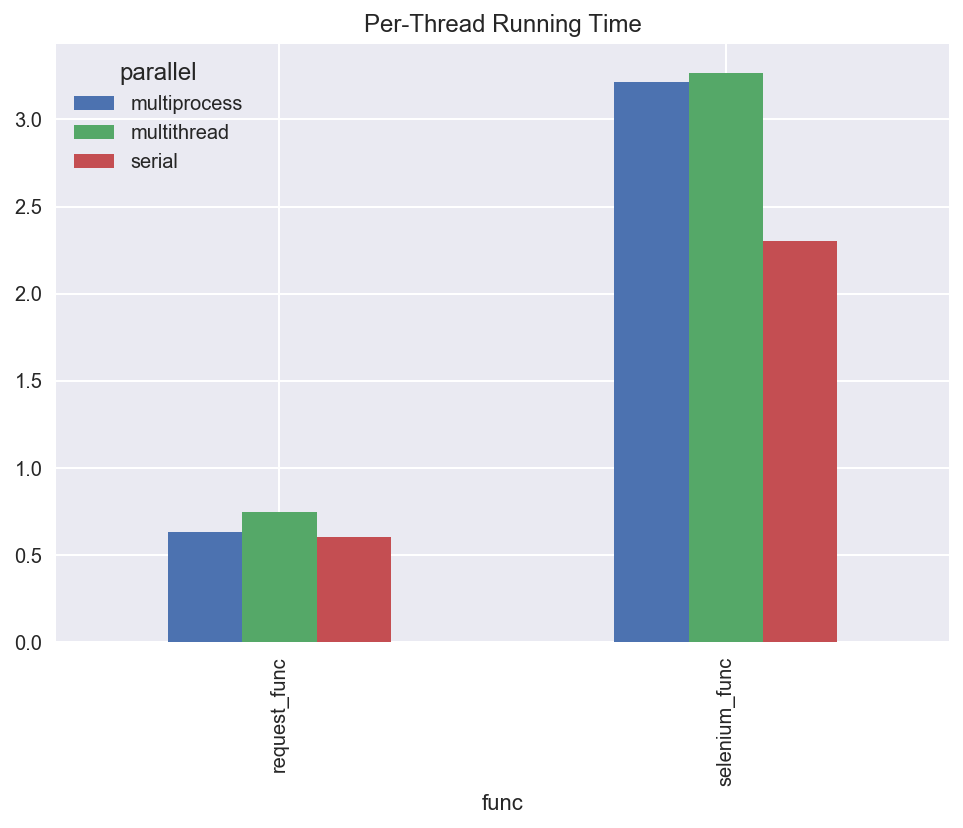

In [3]:
df.groupby(["func", "parallel"])["time"].mean().unstack().plot(kind='bar')
plt.title("Per-Thread Running Time")

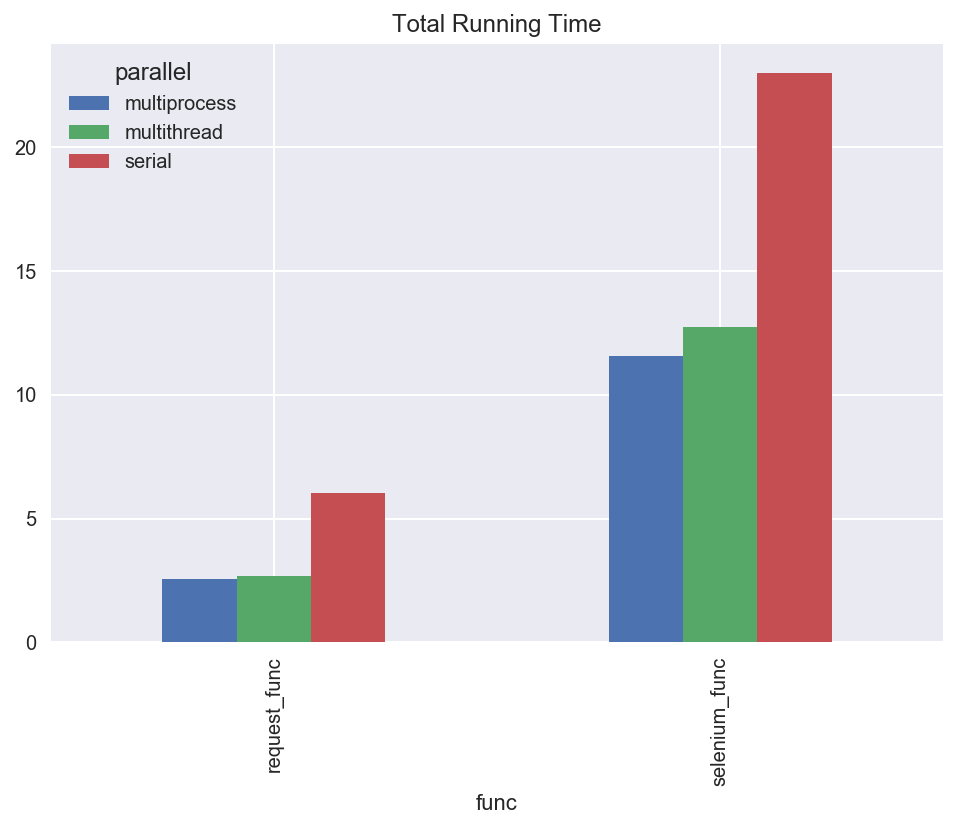

In [4]:
df_total_time = df.groupby(["func", "parallel"]).aggregate({"start": np.min, "end": np.max})
(df_total_time["end"] - df_total_time["start"]).unstack().plot(kind="bar")
plt.title("Total Running Time")